# Grid and Feature Contribution

This document shows the procedure of grid search and feature contribution investigation. 

In [112]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sv = survey('data/survey2/')

In [5]:
sv.num_processor()

In [6]:
df = sv.fin_data

In [7]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)
y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### 1. Fit random forest model

In [8]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Take first 30 important features to model

In [9]:
f30 = rf.feature_importances_.argsort()[::-1][:30]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f30]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [10]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 2. Grid search

In [11]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

#2nd
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2', None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [True, False],
                      'n_estimators': [30, 40,80],
                      'random_state': [1]}

#3rd 
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [60,80,100],
                      'random_state': [1]}
#last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [12]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [13]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   22.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [14]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [15]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.818305210155


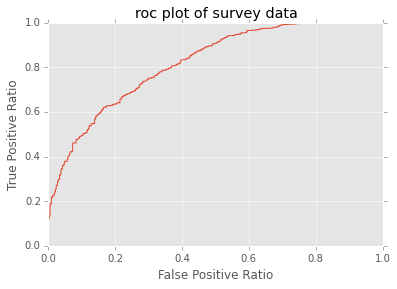

In [16]:
plot_roc(best_rf,X_test,y_test)

### 3.  Tree Interpreter and Feature Contribution

In [17]:
prediction, bias, contributions = ti.predict(best_rf, X_test)

#### make feature contribution data frame

In [37]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [38]:
fc_df['predict'] = best_rf.predict(X_test)    # predicted result

In [39]:
fc_df['employed'] = y_test                   # true result

In [40]:
fc_df['correct'] = fc_df.predict == fc_df.employed      # check if the prediction is correct

In [41]:
fc_df.drop('predict',axis =1, inplace=True)               #subset correct instances

## Clustering Feature Contribution Matrix

* pca
* kmeans on principle components

### PCA

In [42]:
fc_f_pca = fc_df.drop(['employed','correct'],axis =1)       #only pass feature columns to pca

In [43]:
pca = PCA(n_components= 10)
pca.fit(fc_f_pca.values)

PCA(copy=True, n_components=10, whiten=False)

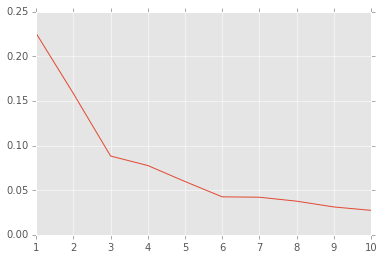

In [44]:
plt.plot(range(1,11),pca.explained_variance_ratio_)

** Three principle components will be fine **

In [45]:
pca = PCA(n_components=4)
fc_pca = pca.fit_transform(fc_f_pca.values)

### Kmeans

To determine which k for kmeans. I wrote a function to check kmeans cluster performance. 

1. put a range k and make a for loop
2. put 

5 clusters
         employed   correct
cluster                    
2        0.861413  0.861413
---
1 out of 5 clusters split the target ideally. rate: 0.2
********************
6 clusters
         employed   correct
cluster                    
3        0.867725  0.867725
5        0.305085  0.762712
---
2 out of 6 clusters split the target ideally. rate: 0.333333333333
********************
7 clusters
         employed   correct
cluster                    
0        0.355263  0.756579
2        0.305085  0.762712
3        0.879699  0.879699
5        0.719540  0.726437
---
4 out of 7 clusters split the target ideally. rate: 0.571428571429
********************
8 clusters
         employed   correct
cluster                    
1        0.702517  0.713959
4        0.310924  0.764706
5        0.869231  0.869231
6        0.261261  0.810811
7        0.769231  0.800000
---
5 out of 8 clusters split the target ideally. rate: 0.625
********************
9 clusters
         employed   correct
cluster  

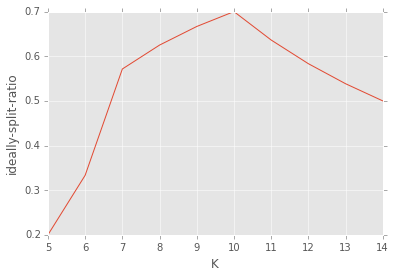

In [107]:
km_emp_mean(fc_pca,15,fc_df.employed,fc_df.correct)

In [134]:
def km_emp(df_pca,krange,empcol,crtcol):
    '''
    apply kmeans to pca-processed dataframe, with a range of k. Then check with k yields clearest employed rate
    and correct rate.
    :param df_pca: numpy array
    :param krange: int, range of k
    :param empcol: panda series
    :param crtcol: panda series
    :return: plot
    '''
    lisT = []
    lisF = []
    df = pd.concat([empcol,crtcol],axis=1)
    for k in xrange(5,krange):
        km = KMeans(n_clusters=k)
        km.fit(df_pca)
        df['cluster'] = km.labels_
        temp = df.groupby('cluster').agg(np.mean)
        resT = temp[(temp['employed'] >0.7) &(temp['correct'] >0.7) ]
        resF = temp[(temp['employed'] < 0.4) &(temp['correct'] >0.7) ]
        lisT.append(resT.shape[0])
        lisF.append(resF.shape[0])
    plt.plot(range(5,krange),lisT,lw = 2, label = 'employed',color = 'blue')
    plt.plot(range(5,krange),lisF, lw = 2, label = 'unemployed', color = 'green')
    plt.legend()
    plt.xlabel('K')
    plt.ylim(0,1)
    #plt.ylabel('ideally-split-ratio')

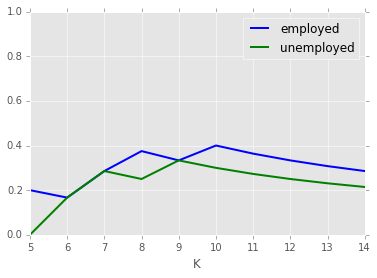

In [133]:
km_emp(fc_pca,15,fc_df.employed,fc_df.correct)

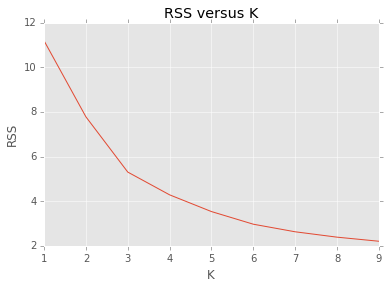

In [46]:
plot_kmean(fc_pca,10)

[autoreload of code.model_vis failed: Traceback (most recent call last):
  File "/Users/yleng/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "code/model_vis.py", line 189
    def
       ^
SyntaxError: invalid syntax
]


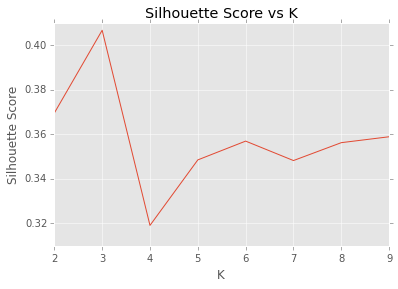

In [47]:
plot_silhouette(fc_pca, 10)

('For n_clusters =', 3, 'The average silhouette_score is :', 0.46521484253708673)


/Users/yleng/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


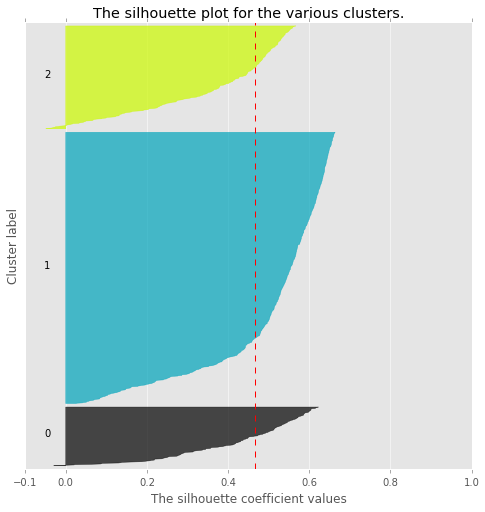

In [29]:
cluster_plot(fc_pca,3)

** Three clusters will be fine**

In [48]:
km = KMeans(n_clusters= 3)
km.fit(fc_pca)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [49]:
fc_df['cluster'] = km.labels_

## Group feature contribution matrix by cluster id